## install

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# !pip install kobert-transformers
# !pip3 install kiwipiepy
!pip install sentence_transformers
!pip install transformers
!pip install konlpy
!pip install tqdm
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

## import

In [2]:
import json
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import itertools
from collections import Counter
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# from kobert_transformers import get_kobert_model,get_tokenizer
# from kobert_tokenizer import KoBERTTokenizer
# from transformers import BertModel

In [3]:
plt.rc('font', family='NanumBarunGothic')

## dataset

In [4]:
with open("./meta_list.json",'r') as f:
  meta_data = json.load(f)

## function definition

In [73]:
def isInKorean(input_s):
  for c in input_s:
      if ord('가') <= ord(c) <= ord('힣'):
          return 1
  return 0

def preprocess_lyrics(samples):
  ret=[]
  for sample in samples:
    if sample:
      s = preprocess_lyric(sample)
      ret.append(s)
  return ret

def preprocess_lyric(sample:str,sep_token:str="[SEP]")->str:
  ret=""
  for sent in lyric.split('\n'):
    if sent:
      sent = sent.strip()
      sent +=sep_token
      ret +=sent
  return ret

## model class

In [6]:
class KoBERT(nn.Module):
  def __init__(self,model,tokenizer,device):
    super(KoBERT,self).__init__()
    self.tokenizer = tokenizer
    self.device = device
    self.model = model.to(device)

  @torch.no_grad()
  def encode(self,x):
    self.model.eval()
    device = self.device
    tokenized_x = self.tokenizer(x,padding='max_length',truncation=True,return_tensors='pt').to(device)
    out = self.model(**tokenized_x).pooler_output
    self.model.train()
    del tokenized_x
    return out.detach().cpu().numpy()
  
  def forward(self,x):
    device = self.device
    tokenized_x = self.tokenizer(x,padding='max_length',truncation=True,return_tensors='pt').to(device)
    return self.model(**tokenized_x)

In [7]:
class KoSBERT(nn.Module):
  def __init__(self,model,tokenizer,device):
    super(KoSBERT,self).__init__()
    self.tokenizer = tokenizer
    self.device = device
    self.model = model.to(device)

  @torch.no_grad()
  def encode(self,x):
    self.model.eval()
    device = self.device
    encoded_x = self.tokenizer(x,padding=True,truncation=True,return_tensors='pt').to(device)
    out = self.model(**encoded_x)
    sentence_embeddings = self.mean_pooling(out, encoded_x['attention_mask'])
    self.model.train()
    return sentence_embeddings.detach().cpu().numpy()
  
  def forward(self,x):
    device = self.device
    encoded_x = self.tokenizer(x,padding=True,truncation=True,return_tensors='pt').to(device)
    return self.model(**encoded_x)
    
  #Mean Pooling - Take attention mask into account for correct averaging
  def mean_pooling(self,model_output, attention_mask):
      token_embeddings = model_output[0] #First element of model_output contains all token embeddings
      input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
      return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

## 키워드 추출
- frequency 기반 추출
  1. mecab을 이용해 전체 가사에서 명사/형용사 추출(중복 제거 X)
  2. 추출된 명사/형용사를 counting해 frequency를 기준으로 키워드를 선택

<br>

- embedding space의 similarity 기반 추출(bert-based)
  1. mecab을 이용해 전체 가사에서 명사/형용사 추출
  2. 명사/형용사에서 중복을 제거해 candidate list를 생성
  3. candidate 중 가사와 embedding space가 가까운 키워드를 선택

  - **문제점**
    1. 가사 길이가 긴 경우 전부 embedding할 수 없다.
      - 길이 단위로 문장 분리한 뒤, batch로 embeddin해 평균을 구한다.

<br>

- TF-IDF score 기반의 추출
  1. mecab을 이용해 전체 가사에서 명사/형용사 추출
  2. 추출된 명사/형용사를 이어붙여 하나의 lyric document를 생성
  3. 전체 lyric에서 document를 생성해 lyric corpus를 생성
  4. corpus와 document에서 TF-IDF score를 이용해 keyword 추출



### making lyric document/corpus

In [8]:
pos_list = ['NNG','NN','VA','AJ']
mecab = Mecab()
n_gram_range = (1,1)

lyric_corpus={}

for key,lyric in tqdm.tqdm_notebook(meta_data['lyric'].items()):
  if lyric is None or len(lyric)<200 or not isInKorean(lyric):
    continue 
  lyric_pos_list = mecab.pos(lyric)
  preprocessed_lyric = preprocess_lyric(lyric)
  selected_lyric_pos_list = [word[0] for word in lyric_pos_list if word[1] in pos_list and len(word[0])>1]
  lyric_doc = ' '.join(selected_lyric_pos_list)
  if not lyric_doc:
    continue
  lyric_corpus[key] = lyric_doc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/1013 [00:00<?, ?it/s]

### frequency 기반 추출

In [9]:
top_n=5
freq_keyword_result={}
for key,lyric_doc in lyric_corpus.items():
  lyric_list = lyric_doc.split(' ')
  freq_keywords = Counter(lyric_list).most_common()[:top_n]
  freq_keyword_result[key]=freq_keywords

In [12]:
for k in freq_keyword_result.keys():
  print('='*100)
  print("title : {}".format(meta_data['track_title'][k]))
  print("artist : {}".format(meta_data['artists'][k]))
  print()
  print("frequency keyword")
  print(freq_keyword_result[k])
  a = input("next..(e to finish)")
  if a=='e':
    break

title : 밤편지
artist : ['아이유(IU)']

frequency keyword
[('사랑', 3), ('그날', 2), ('반딧불', 2), ('파도', 2), ('모래', 2)]
next..(e to finish)
title : 모든 날, 모든 순간 (Every day, Every Moment)
artist : ['폴킴']

frequency keyword
[('순간', 6), ('눈빛', 3), ('송이', 2), ('햇살', 2), ('생각', 1)]
next..(e to finish)
title : 첫눈처럼 너에게 가겠다
artist : ['에일리(Ailee)']

frequency keyword
[('세상', 2), ('숨결', 2), ('우습', 2), ('질투', 2), ('순간', 2)]
next..(e to finish)
title : 벚꽃 엔딩
artist : ['버스커 버스커']

frequency keyword
[('거리', 9), ('벚꽃', 7), ('봄바람', 6), ('사랑', 3), ('바람', 3)]
next..(e to finish)e


### embedding space 기반 추출
  - sentence-bert
  - key-bert

1. 모델 선언

In [14]:
from transformers import AutoTokenizer, AutoModel # using sentencetransformer by huggingface
from sentence_transformers import SentenceTransformer # using sentencetransformer by sentencetransformer library

hug_model = KoSBERT(
    AutoModel.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'),
    AutoTokenizer.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'),
    torch.device("cuda" if torch.cuda.is_available() else 'cpu')
)

# hug_model = KoSBERT(
#     AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v1'),
#     AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v1'),
#     torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# )

# hug_model = KoSBERT(
#     AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'),
#     AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'),
#     torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# )

st_model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens').to(torch.device("cuda" if torch.cuda.is_available() else 'cpu'))

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [48]:
## sentencetransformer lib model 사용

keybert_keyword_result={}

for key,lyric_doc in tqdm.tqdm_notebook(lyric_corpus.items()):
  lyric = meta_data['lyric'][key]
  # preprocessed_lyric = preprocess_lyric(lyric,"</s>")

  count = CountVectorizer(ngram_range=n_gram_range).fit([lyric_doc]) # tokenized_word에서 ngram_range의 단어들을 counting
  candidates = count.get_feature_names_out() # fit된 단어 중 중복이 제거된 단어 list

  doc_embedding = st_model.encode([lyric])
  candidate_embeddings = st_model.encode(candidates.tolist())

  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  keybert_keyword_result[key]=keywords

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/858 [00:00<?, ?it/s]

In [67]:
for k in keybert_keyword_result.keys():
  print('='*100)
  print("title : {}".format(meta_data['track_title'][k]))
  print("artist : {}".format(meta_data['artists'][k]))
  print()
  print("keybert keyword")
  print(keybert_keyword_result[k])
  print("frequency keyword")
  print(freq_keyword_result[k])
  a = input("next..(e to finish)")
  if a=='e':
    break

title : 밤편지
artist : ['아이유(IU)']

keybert keyword
['글씨', '마음', '행운', '입맞춤', '사랑']
frequency keyword
[('사랑', 3), ('그날', 2), ('반딧불', 2), ('파도', 2), ('모래', 2)]
next..(e to finish)
title : 모든 날, 모든 순간 (Every day, Every Moment)
artist : ['폴킴']

keybert keyword
['지금', '불안', '눈물', '순간', '품속']
frequency keyword
[('순간', 6), ('눈빛', 3), ('송이', 2), ('햇살', 2), ('생각', 1)]
next..(e to finish)
title : 첫눈처럼 너에게 가겠다
artist : ['에일리(Ailee)']

keybert keyword
['욕심', '순간', '축복', '행복', '사랑']
frequency keyword
[('세상', 2), ('숨결', 2), ('우습', 2), ('질투', 2), ('순간', 2)]
next..(e to finish)
title : 벚꽃 엔딩
artist : ['버스커 버스커']

keybert keyword
['벚꽃', '노래', '연인', '자장노래', '사랑']
frequency keyword
[('거리', 9), ('벚꽃', 7), ('봄바람', 6), ('사랑', 3), ('바람', 3)]
next..(e to finish)
title : 봄날
artist : ['방탄소년단']

keybert keyword
['연기', '설국', '원망', '순간', '야속']
frequency keyword
[('겨울', 6), ('시간', 3), ('봄날', 3), ('먼지', 2), ('눈꽃', 2)]
next..(e to finish)e


In [50]:
## huggingface model 사용

keybert_keyword_result={}

for key,lyric_doc in tqdm.tqdm_notebook(lyric_corpus.items()):
  lyric = meta_data['lyric'][key]
  # preprocessed_lyric = preprocess_lyric(lyric,"</s>")
  count = CountVectorizer(ngram_range=n_gram_range).fit([lyric_doc]) # tokenized_word에서 ngram_range의 단어들을 counting
  candidates = count.get_feature_names_out() # fit된 단어 중 중복이 제거된 단어 list

  doc_embedding = hug_model.encode([lyric])
  candidate_embeddings = hug_model.encode(candidates.tolist())

  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  keybert_keyword_result[key]=keywords

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/858 [00:00<?, ?it/s]

In [51]:
for k in keybert_keyword_result.keys():
  print('='*100)
  print("title : {}".format(meta_data['track_title'][k]))
  print("artist : {}".format(meta_data['artists'][k]))
  print()
  print("keybert keyword")
  print(keybert_keyword_result[k])
  print("frequency keyword")
  print(freq_keyword_result[k])
  a = input("next..(e to finish)")
  if a=='e':
    break

title : 밤편지
artist : ['아이유(IU)']

keybert keyword
['글씨', '마음', '행운', '입맞춤', '사랑']
frequency keyword
[('사랑', 3), ('그날', 2), ('반딧불', 2), ('파도', 2), ('모래', 2)]
next..(e to finish)
title : 모든 날, 모든 순간 (Every day, Every Moment)
artist : ['폴킴']

keybert keyword
['지금', '불안', '눈물', '순간', '품속']
frequency keyword
[('순간', 6), ('눈빛', 3), ('송이', 2), ('햇살', 2), ('생각', 1)]
next..(e to finish)
title : 첫눈처럼 너에게 가겠다
artist : ['에일리(Ailee)']

keybert keyword
['욕심', '순간', '축복', '행복', '사랑']
frequency keyword
[('세상', 2), ('숨결', 2), ('우습', 2), ('질투', 2), ('순간', 2)]
next..(e to finish)
title : 벚꽃 엔딩
artist : ['버스커 버스커']

keybert keyword
['벚꽃', '노래', '연인', '자장노래', '사랑']
frequency keyword
[('거리', 9), ('벚꽃', 7), ('봄바람', 6), ('사랑', 3), ('바람', 3)]
next..(e to finish)
title : 봄날
artist : ['방탄소년단']

keybert keyword
['연기', '설국', '원망', '순간', '야속']
frequency keyword
[('겨울', 6), ('시간', 3), ('봄날', 3), ('먼지', 2), ('눈꽃', 2)]
next..(e to finish)ㄷ
title : 너를 만나
artist : ['폴킴']

keybert keyword
['괜찮', '수줍', '행복', '배려', '사랑']
f

### TF-IDF 기반

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

lyric_corpus_list = list(lyric_corpus.values())
tfidfv = TfidfVectorizer()
tfidf_matrix = tfidfv.fit_transform(lyric_corpus_list).toarray()
word_list = np.array(tfidfv.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [162]:
indices = np.argpartition(tfidf_matrix,-top_n,axis=1)[:,-top_n:]
indices = np.flip(indices,axis=1)

In [172]:
tfidf_keyword_result={}

for idx,(key,lyric_doc) in tqdm.tqdm_notebook(enumerate(lyric_corpus.items())):
  keywords = word_list[indices[idx]]
  tfidf_keyword_result[key]=keywords.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [164]:
for k in tfidf_keyword_result.keys():
  print('='*100)
  print("title : {}".format(meta_data['track_title'][k]))
  print("artist : {}".format(meta_data['artists'][k]))
  print()
  print("tf-idf keyword")
  print(tfidf_keyword_result[k])
  print("keybert keyword")
  print(keybert_keyword_result[k])
  print("frequency keyword")
  print(freq_keyword_result[k])
  a = input("next..(e to finish)")
  if a=='e':
    break

title : 밤편지
artist : ['아이유(IU)']

tf-idf keyword
['반딧불' '글씨' '모래' '파도' '그날']
keybert keyword
['글씨', '마음', '행운', '입맞춤', '사랑']
frequency keyword
[('사랑', 3), ('그날', 2), ('반딧불', 2), ('파도', 2), ('모래', 2)]
next..(e to finish)
title : 모든 날, 모든 순간 (Every day, Every Moment)
artist : ['폴킴']

tf-idf keyword
['송이' '순간' '눈빛' '햇살' '휴식처']
keybert keyword
['지금', '불안', '눈물', '순간', '품속']
frequency keyword
[('순간', 6), ('눈빛', 3), ('송이', 2), ('햇살', 2), ('생각', 1)]
next..(e to finish)
title : 첫눈처럼 너에게 가겠다
artist : ['에일리(Ailee)']

tf-idf keyword
['숨결' '질투' '주름' '우습' '축복']
keybert keyword
['욕심', '순간', '축복', '행복', '사랑']
frequency keyword
[('세상', 2), ('숨결', 2), ('우습', 2), ('질투', 2), ('순간', 2)]
next..(e to finish)
title : 벚꽃 엔딩
artist : ['버스커 버스커']

tf-idf keyword
['봄바람' '벚꽃' '거리' '오예' '바람']
keybert keyword
['벚꽃', '노래', '연인', '자장노래', '사랑']
frequency keyword
[('거리', 9), ('벚꽃', 7), ('봄바람', 6), ('사랑', 3), ('바람', 3)]
next..(e to finish)e


### extracted keyword distribution

In [176]:
kobert_total_keyword = []
for k in keybert_keyword_result.values():
  kobert_total_keyword.extend(k)
keybert_keyword_counting = Counter(kobert_total_keyword).most_common()

freq_total_keyword=[]
for k in freq_keyword_result.values():
  k_list = [item[0] for item in k]
  freq_total_keyword.extend(k_list)
freq_keyword_counting = Counter(freq_total_keyword).most_common()


tfidf_total_keyword=[]
for k in tfidf_keyword_result.values():
  tfidf_total_keyword.extend(k)
tfidf_keyword_counting = Counter(tfidf_total_keyword).most_common()

In [177]:
print(keybert_keyword_counting[:10])
print(freq_keyword_counting[:10])
print(tfidf_keyword_counting[:10])

[('사랑', 377), ('행복', 128), ('눈물', 120), ('순간', 98), ('괜찮', 87), ('마음', 76), ('얘기', 65), ('기분', 60), ('마지막', 47), ('약속', 45)]
[('사랑', 373), ('사람', 125), ('마음', 101), ('눈물', 100), ('시간', 81), ('생각', 75), ('세상', 74), ('기억', 69), ('가슴', 68), ('오늘', 65)]
[('사랑', 185), ('사람', 61), ('눈물', 48), ('마음', 46), ('가슴', 40), ('기억', 38), ('행복', 37), ('바보', 36), ('세상', 34), ('생각', 33)]


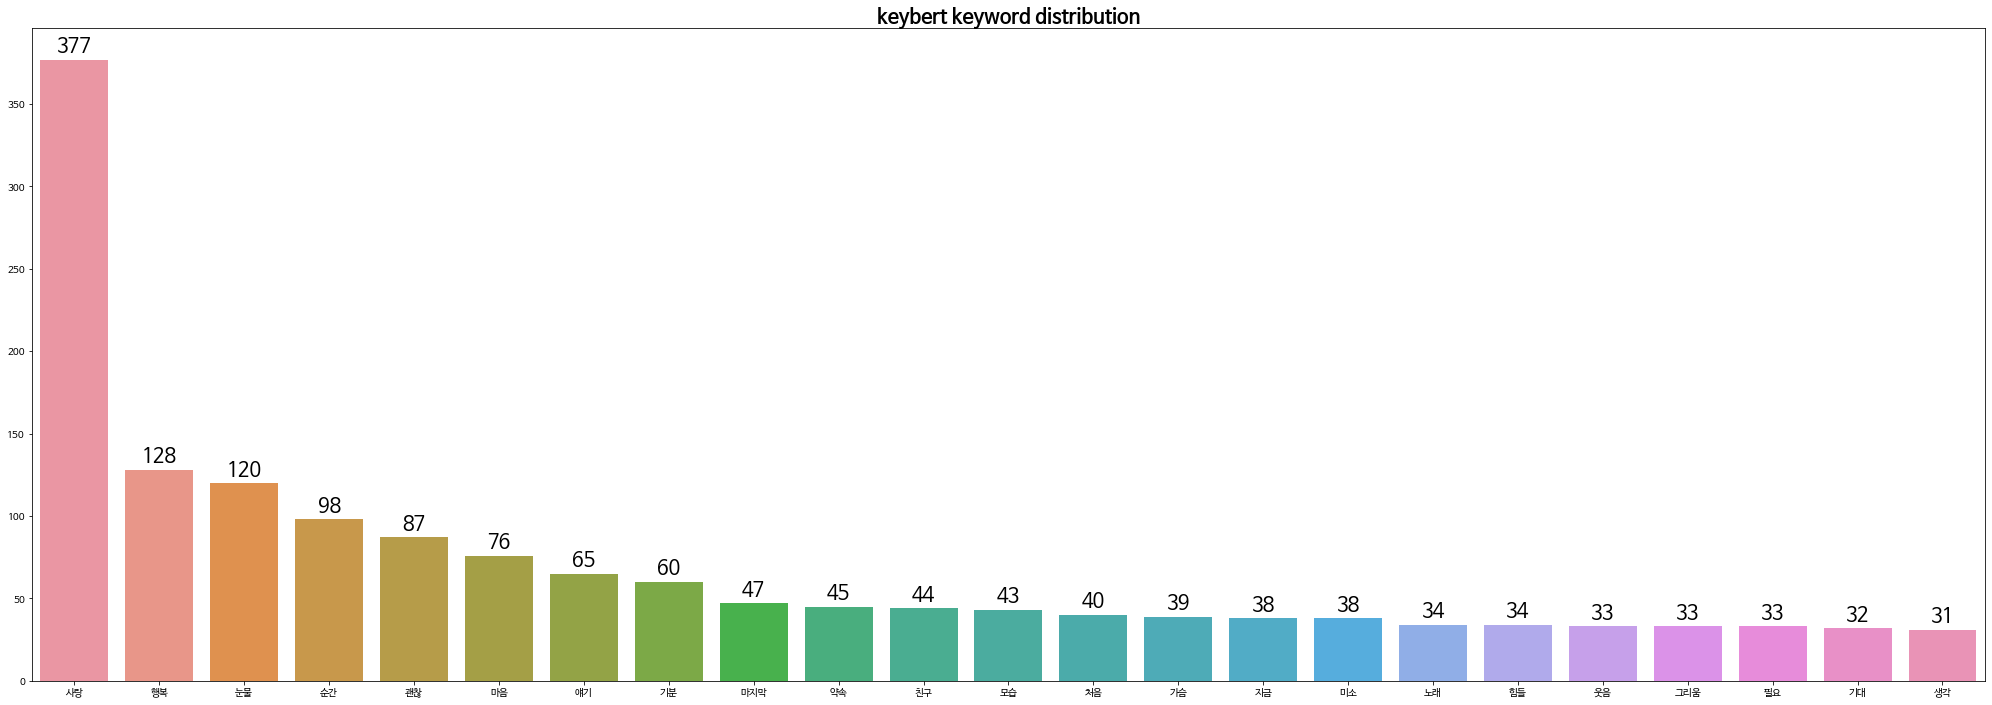

In [178]:
freq_tresh = 30
x = list([items[0] for items in keybert_keyword_counting if items[1] >= freq_tresh])
y = list([items[1] for items in keybert_keyword_counting if items[1] >= freq_tresh])
plt.figure(figsize=(35,12))
ax = sns.barplot(x=x,y=y)
ax.set_title("keybert keyword distribution",fontdict={"fontsize":20,"fontweight":"bold"})
for i, v in enumerate(y):
    ax.text(i, v+5, str(v), fontdict={"fontsize":20},ha='center')
plt.show()

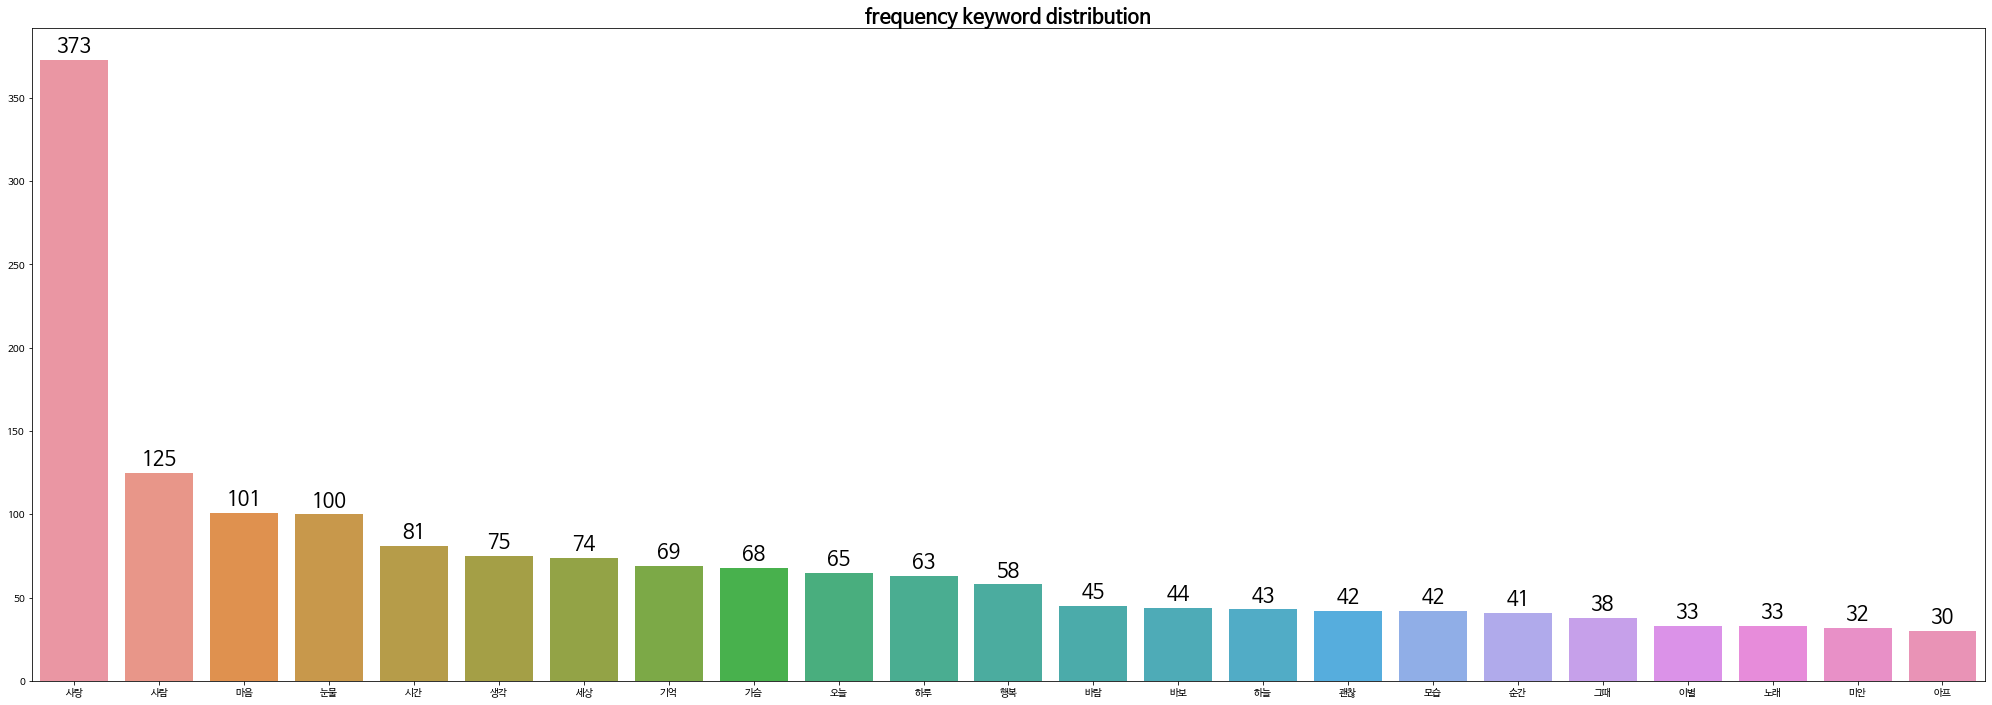

In [179]:
freq_tresh = 30
x = list([items[0] for items in freq_keyword_counting if items[1] >= freq_tresh])
y = list([items[1] for items in freq_keyword_counting if items[1] >= freq_tresh])
plt.figure(figsize=(35,12))
ax = sns.barplot(x=x,y=y)
ax.set_title("frequency keyword distribution",fontdict={"fontsize":20,"fontweight":"bold"})
for i, v in enumerate(y):
    ax.text(i, v+5, str(v), fontdict={"fontsize":20},ha='center')
plt.show()

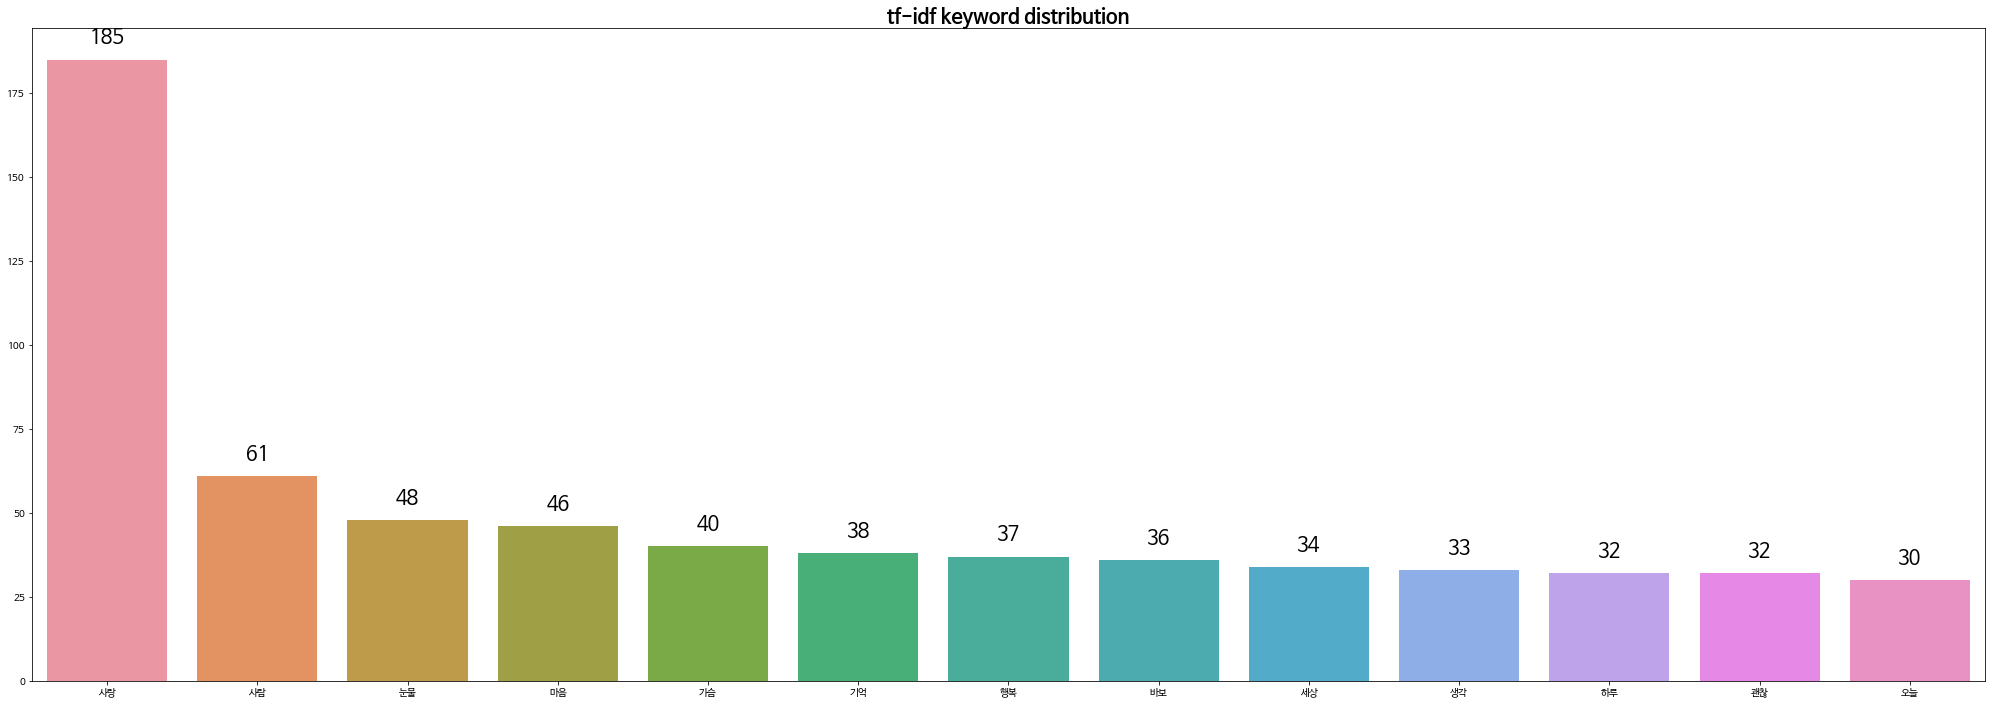

In [180]:
freq_tresh = 30
x = list([items[0] for items in tfidf_keyword_counting if items[1] >= freq_tresh])
y = list([items[1] for items in tfidf_keyword_counting if items[1] >= freq_tresh])
plt.figure(figsize=(35,12))
ax = sns.barplot(x=x,y=y)
ax.set_title("tf-idf keyword distribution",fontdict={"fontsize":20,"fontweight":"bold"})
for i, v in enumerate(y):
    ax.text(i, v+5, str(v), fontdict={"fontsize":20},ha='center')
plt.show()